# LSTM vs SVM

Juan Navarro, <jsnavarroa@unal.edu.co>

-------------------------------


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

%matplotlib inline

In [2]:
data_path = os.path.abspath("./data")

## 1. Load dataset and preprocessing

In [3]:
import pandas as pd
from sklearn import preprocessing

dataset = pd.read_csv(data_path+"/data.csv")

dataset['Fecha corte'] = pd.DatetimeIndex(dataset['Fecha corte'])

profit = dataset[['Rentab. dia']]

print(dataset.shape)
dataset.head()

(507, 6)


,Fecha corte,Núm. unidades,Valor unidad para las operaciones del día t,Valor fondo al cierre del día t,Núm. Invers.,Rentab. dia
0,2017-01-01,0.000000,0.000000,0.000000,0.000000,0.390802
1,2017-01-02,0.000000,0.002783,0.096858,0.002702,0.426929
2,2017-01-03,0.132521,0.005535,0.171329,0.004203,0.424364
3,2017-01-04,0.234118,0.007485,0.237531,0.006965,0.349377
4,2017-01-05,0.324609,0.009300,0.223134,0.009907,0.336811


## 2. Time series to supervised problem

In [4]:
# https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a DataFrame.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = data.size
    df = data
    cols = data.drop(data.columns[0], axis=1)
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        name = 'var(t-{})'.format(i)
        cols[name] = df.shift(i)
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        if i == 0:
            name = 'var(t)'
        else:
            name = 'var(t+{})'.format(i)
            
        cols[name] = df.shift(-i)
    
    # drop rows with NaN values
    if dropnan:
        cols.dropna(inplace=True)
    return cols

In [5]:
data = series_to_supervised(profit, 2, 2)

# Merge on index
data = dataset.merge(data, left_index=True, right_index=True)
data = data.drop(columns=['Rentab. dia']) # the same of var(t)

print(data.info())

data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 504 entries, 2 to 505
Data columns (total 9 columns):
Fecha corte                                    504 non-null datetime64[ns]
Núm. unidades                                  504 non-null float64
Valor unidad para las operaciones del día t    504 non-null float64
Valor fondo al cierre del día t                504 non-null float64
Núm. Invers.                                   504 non-null float64
var(t-2)                                       504 non-null float64
var(t-1)                                       504 non-null float64
var(t)                                         504 non-null float64
var(t+1)                                       504 non-null float64
dtypes: datetime64[ns](1), float64(8)
memory usage: 39.4 KB
None


,Fecha corte,Núm. unidades,Valor unidad para las operaciones del día t,Valor fondo al cierre del día t,Núm. Invers.,var(t-2),var(t-1),var(t),var(t+1)
2,2017-01-03,0.132521,0.005535,0.171329,0.004203,0.390802,0.426929,0.424364,0.349377
3,2017-01-04,0.234118,0.007485,0.237531,0.006965,0.426929,0.424364,0.349377,0.336811
4,2017-01-05,0.324609,0.009300,0.223134,0.009907,0.424364,0.349377,0.336811,0.482573
5,2017-01-06,0.303999,0.012669,0.246427,0.012926,0.349377,0.336811,0.482573,0.390739
6,2017-01-07,0.334702,0.015066,0.247157,0.012926,0.336811,0.482573,0.390739,0.387894


In [6]:
from sklearn.model_selection import train_test_split

date = data['Fecha corte']

data = data.drop(columns=['Fecha corte'], errors='ignore')

features = data.shape[1]

X = data.iloc[:, 0:features-1]
y = data.iloc[:, features-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_train.head()

77     0.342066
444    0.338797
17     0.385566
327    0.306552
390    0.301359
Name: var(t+1), dtype: float64

## 3. Support Vector Regression

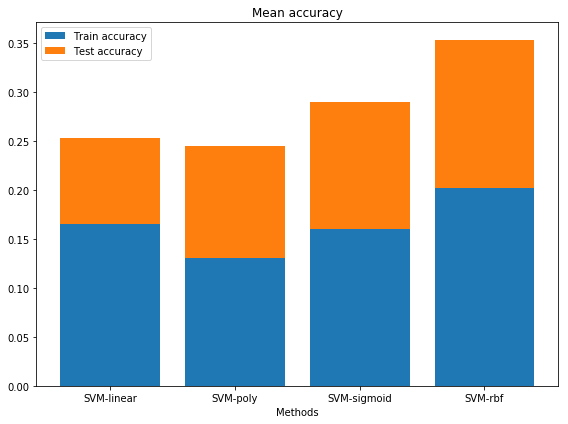

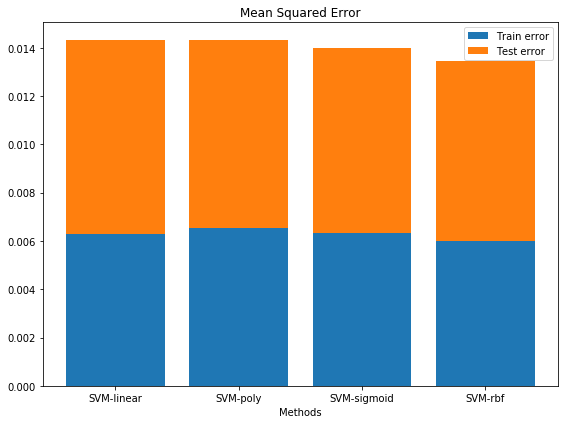

In [7]:
from sklearn import svm
from sklearn.metrics import mean_squared_error, accuracy_score

kernels = ['linear', 'poly', 'sigmoid', 'rbf']

methods = []
train_scores = []
test_scores = []
train_errors = []
test_errors = []

# Calcs for SVM
for kernel in kernels:
    methods.append('SVM-'+kernel)
    clf_svr = svm.SVR(kernel=kernel)
    clf_svr.fit(X_train, y_train)

    y_train_pred = clf_svr.predict(X_train)
    y_test_pred = clf_svr.predict(X_test)
    
    train_score = clf_svr.score(X_train, y_train)
    train_scores.append(train_score)
    
    test_score = clf_svr.score(X_test, y_test)
    test_scores.append(test_score)
    
    train_error = mean_squared_error(y_train, y_train_pred)
    train_errors.append(train_error)
    
    test_error = mean_squared_error(y_test, y_test_pred)
    test_errors.append(test_error)
    
def plot_accuracy(methods, train_scores, test_scores, fig_file=None):
    r, c = (1, 1)
    fig, axes = plt.subplots(r, c, figsize=(8*c, 6*r))
    axes = np.array(axes).reshape(-1)

    ax = axes[0]
    ax.bar(methods, train_scores, label='Train accuracy')
    ax.bar(methods, test_scores, label='Test accuracy', bottom=train_scores)
    ax.set_xlabel("Methods")
    ax.set_title("Mean accuracy")
    ax.legend()

    plt.tight_layout()
    if fig_file:
        plt.savefig(fig_file)
    plt.show()
    
def plot_mse(methods, train_errors, test_errors, fig_file=None):
    r, c = (1, 1)
    fig, axes = plt.subplots(r, c, figsize=(8*c, 6*r))
    axes = np.array(axes).reshape(-1)

    ax1 = axes[0]
    ax1.bar(methods, train_errors, label='Train error')
    ax1.bar(methods, test_errors, label='Test error', bottom=train_errors)
    ax1.set_xlabel("Methods")
    ax1.set_title("Mean Squared Error")
    ax1.legend()

    plt.tight_layout()
    if fig_file:
        plt.savefig(fig_file)
    plt.show()
    
plot_accuracy(methods, train_scores, test_scores, fig_file='svr-accuracy.png')
plot_mse(methods, train_errors, test_errors, fig_file=None)

/home/juan/Programas/Miniconda3/envs/ml/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


(403, 7)
(403, 1, 7) (403,) (101, 1, 7) (101,)


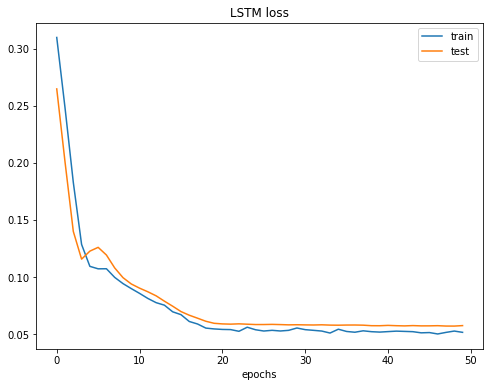

In [8]:
from keras.models import Sequential
from keras import layers

print(X_train.shape)

# reshape input to be 3D [samples, timesteps, features]
full_X = X.values.reshape((X.shape[0], 1, X.shape[1]))
train_X = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
test_X = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))
train_y = y_train
test_y = y_test
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(layers.LSTM(units=50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(layers.Dropout(rate=0.1))
model.add(layers.Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, 
                    validation_data=(test_X, test_y), verbose=0, shuffle=False)

# plot history
r, c = (1, 1)
fig, axes = plt.subplots(r, c, figsize=(8*c, 6*r))
axes = np.array(axes).reshape(-1)

ax = axes[0]
ax.plot(history.history['loss'], label='train')
ax.plot(history.history['val_loss'], label='test')
ax.set_title('LSTM loss')
ax.set_xlabel('epochs')
ax.legend()

plt.show()

(403, 1)
0.006409020113040241


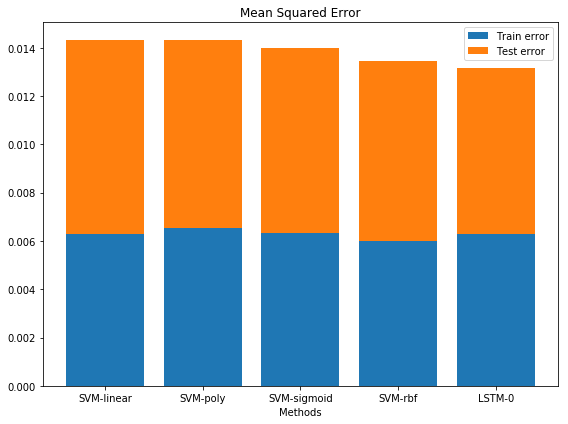

In [9]:
y_pred_lstm = model.predict(train_X)
print(y_pred_lstm.shape)
print(mean_squared_error(y_train, y_pred_lstm))

models = [model]

# Calcs for LSTM
for i, model in enumerate(models):
    methods.append('LSTM-' + str(i))
    
    # fit network
    history = model.fit(train_X, train_y, epochs=50, batch_size=72, 
                    validation_data=(test_X, test_y), verbose=0, shuffle=False)

    y_train_pred = model.predict(train_X)
    y_test_pred = model.predict(test_X)
    
    train_error = mean_squared_error(y_train, y_train_pred)
    train_errors.append(train_error)
    
    test_error = mean_squared_error(y_test, y_test_pred)
    test_errors.append(test_error)

plot_mse(methods, train_errors, test_errors, fig_file='mse.png')

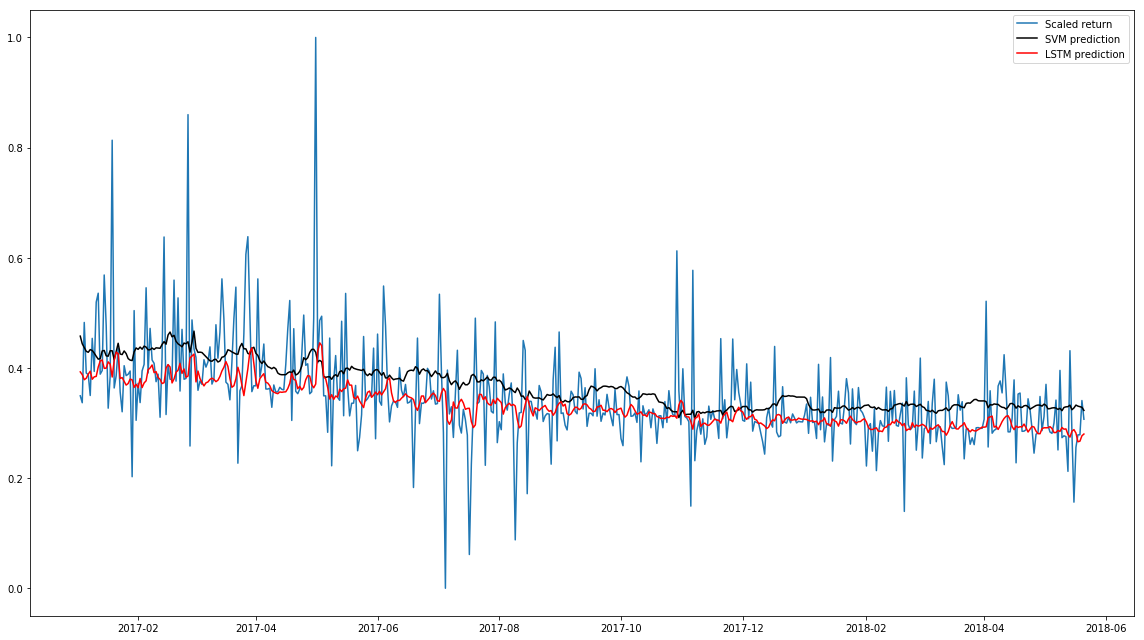

In [10]:
# Plot predictions
r, c = (1, 1)
fig, axes = plt.subplots(r, c, figsize=(16*c, 9*r))
axes = np.array(axes).reshape(-1)

ax = axes[0]
ax.plot(date, y, label='Scaled return')
ax.plot(date, clf_svr.predict(X), label='SVM prediction', c='black')
ax.plot(date, model.predict(full_X), label='LSTM prediction', c='red')
ax.legend()

plt.tight_layout()
plt.savefig('prediction.png')
plt.show()